# Evaluación de diferencias en reservas de vuelos por nivel educativo

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, kstest

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames 

In [3]:
df = pd.read_csv('files/datos_totales_clean.csv')

In [ ]:
df.head(1)

,loyalty_number,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_year,cancellation_month,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,still_client_loyalty,salary_range
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,0,0,2017,1,0,0,0,0,0.0,0,0,si,bajo


## 1. Preparación y agrupación de datos

In [ ]:
df['education'].unique()

array(['Bachelor', 'College', 'Master', 'High School or Below', 'Doctor'],
      dtype=object)

In [ ]:
#vamos a ordenar estos valores únicos por nivel de formación:
lista = ['High School or Below','College', 'Bachelor', 'Master', 'Doctor']

In [ ]:
# filtramos los datos para obtener los grupos. Estos grupos van a ser series de datos
grupo_high_school = df[df['education'] == 'High School or Below'] ['flights_booked']
grupo_college = df[df['education'] == 'College'] ['flights_booked']
grupo_bachelor = df[df['education'] == 'Bachelor'] ['flights_booked']
grupo_master = df[df['education'] == 'Master'] ['flights_booked']
grupo_doctor = df[df['education'] == 'Doctor'] ['flights_booked']

In [ ]:
df_grupo_high_school = pd.DataFrame(grupo_high_school)
df_grupo_college = pd.DataFrame(grupo_college)
df_grupo_bachelor = pd.DataFrame(grupo_bachelor)
df_grupo_master = pd.DataFrame(grupo_master)
df_grupo_doctor = pd.DataFrame(grupo_doctor)

In [ ]:
df_grupo_high_school.head()

,flights_booked
792,9
793,2
794,13
795,9
796,0


## 2. Análisis descriptivo

In [ ]:
#imprimimos las estadísticas:
for filtro in lista:
    print(filtro)
    display(df[df['education'] == filtro]['flights_booked'].describe().round(2).reset_index().T)
    print('-' * 40)

High School or Below


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
flights_booked,18768.0,4.21,5.3,0.0,0.0,1.0,8.0,31.0


----------------------------------------
College


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
flights_booked,101712.0,4.19,5.29,0.0,0.0,1.0,8.0,38.0


----------------------------------------
Bachelor


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
flights_booked,251400.0,4.13,5.26,0.0,0.0,1.0,8.0,39.0


----------------------------------------
Master


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
flights_booked,12192.0,4.23,5.27,0.0,0.0,1.0,8.0,33.0


----------------------------------------
Doctor


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
flights_booked,17616.0,4.2,5.31,0.0,0.0,1.0,8.0,32.0


----------------------------------------


Viendo los estadísticos, parece que pueden haber diferencias a partir del tercer cuartil, es decir, los valores más altos de la serie, que puden ser `outliers`. Vamos a hacer un `boxplot` para comprobarlo:

''

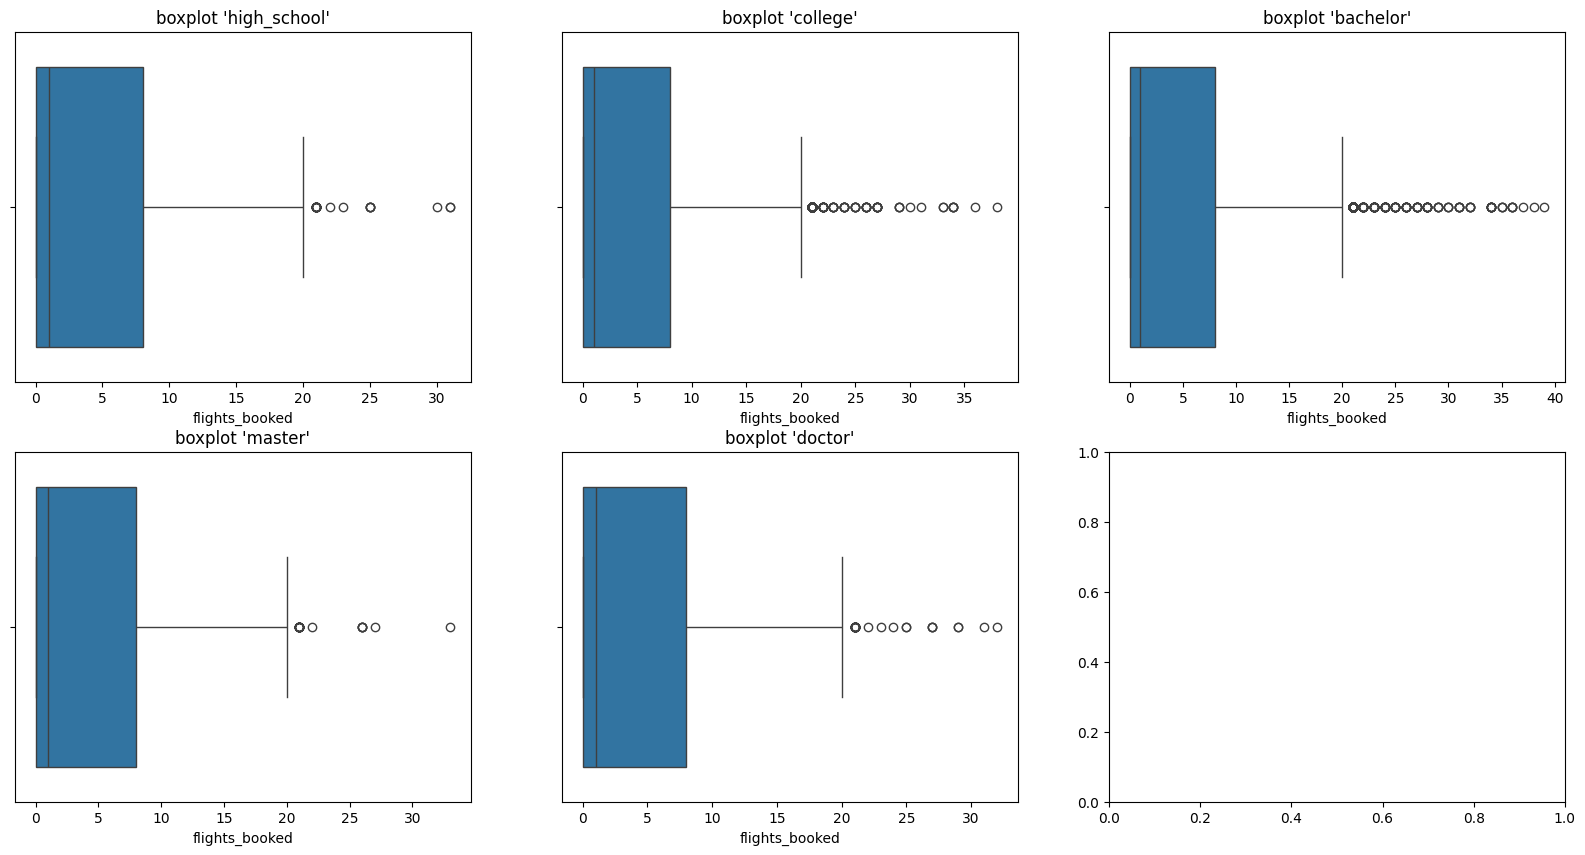

In [ ]:
#Boxplot
#empezamos creando el subplot con el número de gráficas deseadas en su interior
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

sns.boxplot(x = "flights_booked", 
            data = df_grupo_high_school, 
            ax = axes[0,0])
axes[0,0].set_title("boxplot 'high_school'")

sns.boxplot(x = "flights_booked", 
            data = df_grupo_college, 
            ax = axes[0,1])
axes[0,1].set_title("boxplot 'college'")


sns.boxplot(x = "flights_booked", 
            data = df_grupo_bachelor, 
            ax = axes[0,2])
axes[0,2].set_title("boxplot 'bachelor'")

sns.boxplot(x = "flights_booked", 
            data = df_grupo_master,  
            ax = axes[1,0])
axes[1,0].set_title("boxplot 'master'")

sns.boxplot(x = "flights_booked", 
            data = df_grupo_doctor,  
            ax = axes[1,1])
axes[1,1].set_title("boxplot 'doctor'");

En todas, aunque sobre todo en `College`, `bachelor` y `doctor`, hay bastantes observaciones que se salen de del rango intercuatílico. Esto puede ser de gran ayuda de cara a analizar la prueba de hipótesis que tenemos a continuación, porque parece que sí habrá una diferencia en el número de vuelos reservados y los diferentes niveles educativos.

## 3. Prueba de hipótesis:

- `H0 (Hipótesis nula)` = no existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

- `H1 (Hipótesis alternativa)` = Existe diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.


### `Estructura de prueba de hipótesis`:

1. Primero verificamos si los datos son normales  
- usando el test de Shapiro-Wilk (menos de 5.000 datos) o 
- Kolmogorov-Smirnov (más de 5.000 datos en muestra). 

-- > ahora haremos el test, pero con un `histograma`, podemos ver si la distribución es normal:

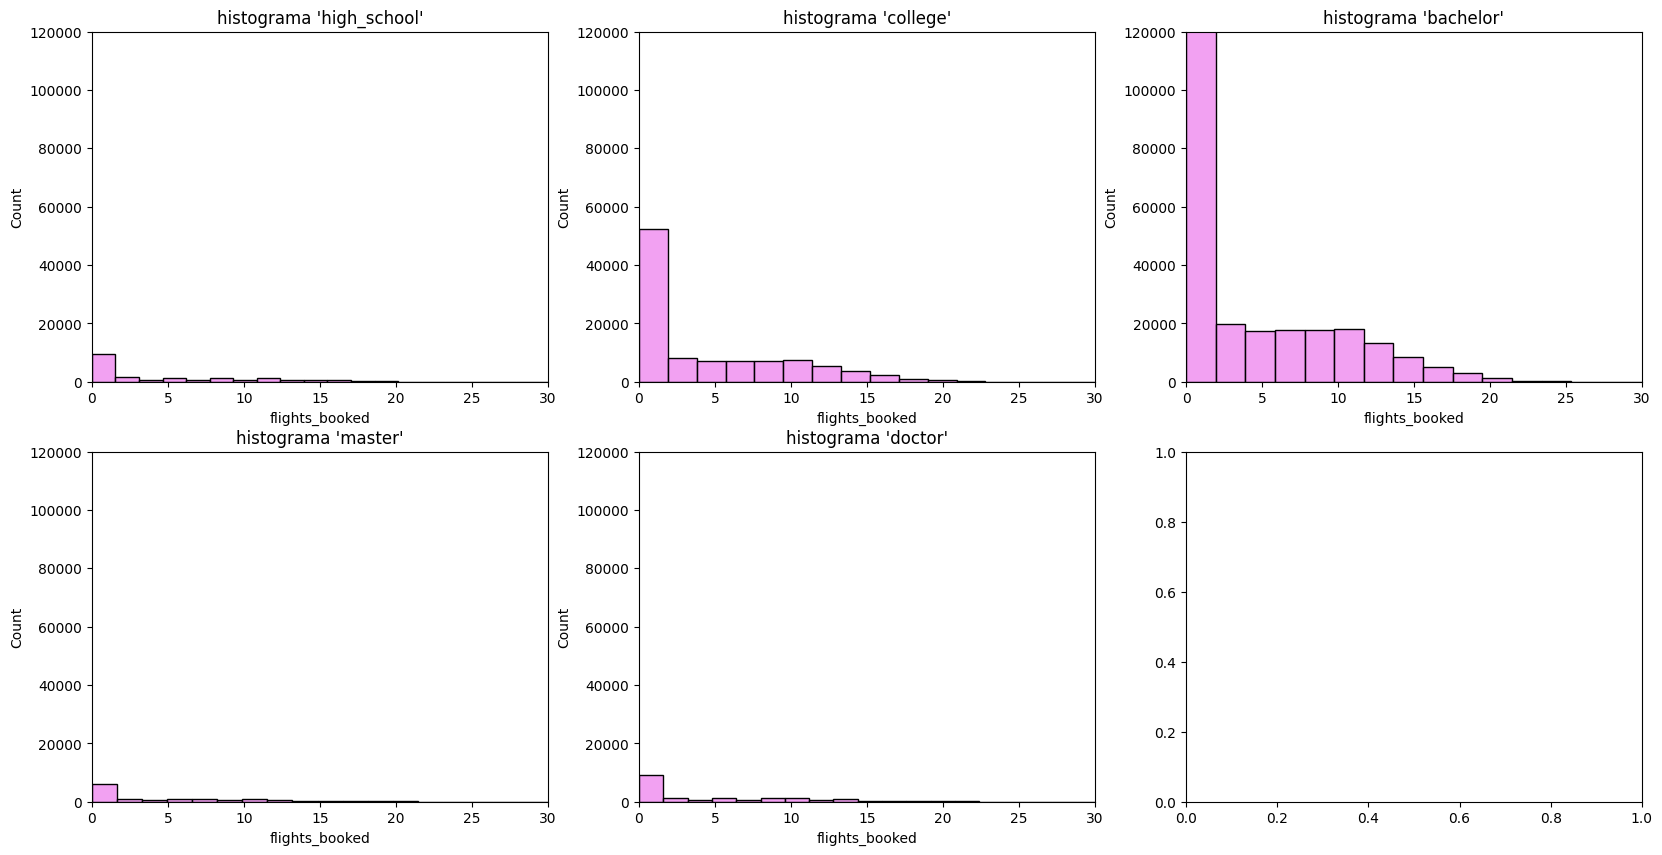

In [ ]:
#Histograma
#empezamos creando el subplot con el número de gráficas deseadas en su interior
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))

sns.histplot(x = "flights_booked", 
            data = df_grupo_high_school, 
            color = "violet", 
            bins = 20, 
            ax = axes[0,0])
axes[0,0].set_title("histograma 'high_school'")

sns.histplot(x = "flights_booked", 
            data = df_grupo_college, 
            color = "violet", 
            bins = 20, 
            ax = axes[0,1])
axes[0,1].set_title("histograma 'college'")


sns.histplot(x = "flights_booked", 
            data = df_grupo_bachelor, 
            color = "violet", 
            bins = 20, 
            ax = axes[0,2])
axes[0,2].set_title("histograma 'bachelor'")

sns.histplot(x = "flights_booked", 
            data = df_grupo_master, 
            color = "violet", 
            bins = 20, 
            ax = axes[1,0])
axes[1,0].set_title("histograma 'master'")

sns.histplot(x = "flights_booked", 
            data = df_grupo_doctor, 
            color = "violet", 
            bins = 20, 
            ax = axes[1,1])
axes[1,1].set_title("histograma 'doctor'");

#ponemos la misma escala en los ejes:
#eje x, para asegurarnos que coge bien el mes núm 12:
axes[0,0].set_xlim(0,30) 
axes[0,1].set_xlim(0,30) 
axes[0,2].set_xlim(0,30) 
axes[1,0].set_xlim(0,30) 
axes[1,1].set_xlim(0,30) 

#eje y, hasta 120.000:
axes[0,0].set_ylim(0,120000) 
axes[0,1].set_ylim(0,120000) 
axes[0,2].set_ylim(0,120000) 
axes[1,0].set_ylim(0,120000) 
axes[1,1].set_ylim(0,120000);

 2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    -  Por el histograma, no parece que vayan a ser normales, tendremos que usar Levene.

 3. Si las varianzas son iguales, usa el t-test de Student si no, usa la versión de Welch (ambos son tests Paramétricos).

 4. Si los datos no son normales, usa el test de Mann-Whitney (alternativa no paramétrica).

In [ ]:
def prueba_hipotesis(*args):
    """
    Realiza una prueba de hipótesis para comparar grupos.
    1. Primero verifica si los datos son normales usando el test de Shapiro-Wilk (menos de 5.000 datos) o Kolmogorov-Smirnov (más de 5.000 datos en muestra).
    2. Si los datos son normales, usa Bartlett para probar igualdad de varianzas. Si no son normales, usa Levene.
    3. Si estamos comparando dos grupos a la vez:
        3.1.Si las varianzas son iguales, usa el t-test de Student si no, usa la versión de Welch (ambos son tests Paramétricos).
        3.2.Si los datos no son normales, y son sólo dos grupos: se usa el test de Mann-Whitney (alternativa no paramétrica), en el caso de que haya más de dos grupos, .
    4. Si estamos comparando más de dos grupos a la vez:
        4.1. Usa ANOVA (si los datos son normales) o Kruskal-Wallis (si no son normales).
        4.2. Usa Kruskal-Wallis si datos NO normales.

    Parámetros:
    *args: listas o arrays con los datos de cada grupo.

    Retorna:
    dict con resultados del test de normalidad, varianza e hipótesis.
    """
    # Inicializar variables para evitar error, porque t_stat y p_valor solo se asignan dentro de las condiciones if-else, 
    # pero si ninguna de esas condiciones se cumple, las variables nunca se definen, lo que genera el error cuando intentas acceder a ellas
    t_stat, p_valor, test_usado = None, None, None
    
    # PASO 1: Comprobar normalidad en cada grupo
    normalidad = []
    for grupo in args:
        if len(grupo) > 5000:
            p_valor_norm = stats.kstest(grupo, 'norm').pvalue  # Kolmogorov-Smirnov si n > 5000 
        else:
            p_valor_norm = stats.shapiro(grupo).pvalue  # Shapiro-Wilk si n <= 5000(Hasta 5000 saphiro es robusto, aunque depende tb de otras cosas)
        normalidad.append(p_valor_norm > 0.05)
    #nota: p_valor_norm > 0.05:
    #Si True, significa que no hay suficiente evidencia para rechazar la hipótesis nula (es decir, los datos podrían seguir una distribución normal).
    #Si False, significa que hay suficiente evidencia para rechazar la normalidad.
    

    # PASO 2: Prueba de igualdad de varianzas:
    datos_normales = all(normalidad)  
    # La función all(iterable) en Python: all() devuelve True sólo si todos los elementos en normalidad son True.
    # Si al menos un elemento es False, entonces all() devuelve False. 
    # Es decir, si datos_normales = True, significa que todos los grupos pasaron la prueba de normalidad. 
    # Si datos_normales = False, significa que al menos un grupo no es normal.

    # Prueba de igualdad de varianzas
    if datos_normales: #(if datos_normales == True)
        p_valor_varianza = stats.bartlett(*args).pvalue  # Test de Bartlett si los datos son normales
    else:
        p_valor_varianza = stats.levene(*args, center="median").pvalue  # Test de Levene si no son normales


    # PASO 3 y PASO 4: Aplicar el test adecuado:

    varianzas_iguales = p_valor_varianza > 0.05 
    # Si p_valor_varianza > 0.05, no hay suficiente evidencia para decir que las varianzas son diferentes 
    # → Se asume que las varianzas son iguales (varianzas_iguales = True).

    # OPCIÓN 1: sólo para comparar 2 grupos.

    if len(args) == 2: 
        if datos_normales:
            if varianzas_iguales:
                # el t-test de Student sólo se puede usar cuando no hay normalidad y cuando se pretenden comparar 2 grupos.
                t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
                test_usado = "t-test de Student (varianzas iguales)"
            else:
                t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
                test_usado = "t-test de Welch (varianzas desiguales)"
        #Mann-Whitney U: este test sólo se puede usar cuando no hay normalidad y cuando se pretenden comparar 2 grupos.
        else:
            t_stat, p_valor = stats.mannwhitneyu(*args)
            test_usado = "Mann-Whitney U (prueba no paramétrica)"


    # OPCIÓN 2: para comparar 2 grupos o más   
    
    elif len(args) > 2:  # Para más de dos grupos
        # ANOVA si datos normales
        if datos_normales:
            t_stat, p_valor = stats.f_oneway(*args) 
            test_usado = "ANOVA (prueba paramétrica)"
        # Kruskal-Wallis si datos NO normales
        else:
            t_stat, p_valor = stats.kruskal(*args)
            test_usado = "Kruskal-Wallis (prueba no paramétrica)"

    else:
        raise ValueError("Se necesitan al menos dos conjuntos de datos.")

    # Nivel de significancia
    alfa = 0.05

    # Resultados
    resultado = {
        "Test de Normalidad": normalidad,
        "Datos Normales": datos_normales,
        "p-valor Varianza": p_valor_varianza,
        "Varianzas Iguales": varianzas_iguales,
        "Test Usado": test_usado,
        "Estadístico": t_stat,
        "p-valor": p_valor,
        "Conclusión": "Rechazamos H0 (Hay diferencias significativas)" if p_valor < alfa else "No se rechaza H0 (No hay diferencias significativas)"
    }

    # Imprimir resultados de manera más clara
    print("**📌 Resultados de la Prueba de Hipótesis**")
    print(f"Test de Normalidad: {'Sí' if datos_normales else 'No'}")
    print(f"Normalidad por grupo: {normalidad}")
    print(f"Test de Varianza: {'Iguales' if varianzas_iguales else 'Desiguales'} (p = {p_valor_varianza:.4f})")
    print(f"Test aplicado: {test_usado}")
    print(f" Estadístico: {t_stat:.4f}, p-valor: {p_valor:.4f}")
    print(f"🔍 Conclusión: {resultado['Conclusión']}")

    return resultado

In [ ]:
prueba_hipotesis(grupo_high_school, grupo_college, grupo_bachelor, grupo_master, grupo_doctor)

**📌 Resultados de la Prueba de Hipótesis**
Test de Normalidad: No
Normalidad por grupo: [np.False_, np.False_, np.False_, np.False_, np.False_]
Test de Varianza: Desiguales (p = 0.0038)
Test aplicado: Kruskal-Wallis (prueba no paramétrica)
 Estadístico: 18.7151, p-valor: 0.0009
🔍 Conclusión: Rechazamos H0 (Hay diferencias significativas)


{'Test de Normalidad': [np.False_, np.False_, np.False_, np.False_, np.False_],
 'Datos Normales': False,
 'p-valor Varianza': np.float64(0.0038152909032901144),
 'Varianzas Iguales': np.False_,
 'Test Usado': 'Kruskal-Wallis (prueba no paramétrica)',
 'Estadístico': np.float64(18.71507053972487),
 'p-valor': np.float64(0.0008939855290647737),
 'Conclusión': 'Rechazamos H0 (Hay diferencias significativas)'}

Rescatamos nuestras hipótesis:

- `H0 (Hipótesis nula)` = no existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.

- `H1 (Hipótesis alternativa)` = Existe diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos.



### `Conclusión`:

Tal y como vimos arriba con los boxplots, sí hay una diferencia entre el número de vuelos reservados y los diferentes niveles educativos.



-- > Rechazamos la `H0 (Hipótesis nula)` porque hay diferencias significativas.

